In [13]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, minimize
import math
import sys
from typing import Callable, Tuple, Optional
from dataclasses import dataclass
import pandas as pd

PI=np.pi
R=8.314



In [14]:
@dataclass
class WardTordaiParams:
    """
    Data class to hold parameters for the Ward-Tordai model with various isotherms.
    """
    # Global parameters
    Cb: float = 1.0e-2        # Bulk concentration (mol/m^3)
    D: float = 8.8e-10        # Diffusion coefficient (m^2/s)
    rb: float = 1.12e-3       # Radius of the bubble (m)
    Tmpr: float = 298.15      # Temperature (K)
    gamma_0: float = 72.2e-3  # Solvent surface tension (N/m)

    # Isotherm constants
    gamma_m: float = 3.91e-6  # Maximum surface concentration (mol/m^2)
    kh: float = 2146.0        # Henry constant (m)
    kl: float = 2146.0        # Langmuir constant (m^3/mol)
    kf: float = 0.0           # Frumkin constant (m^3/mol)
    A: float = 0.0            # Frumkin interaction parameter
    kfl: float = 0.0          # Freundlich constant (mol^x m^y)
    knl: float = 1.0          # Freundlich consistency index
    kv: float = 0.0           # Volmer constant (m^3/mol)
    nn: float = 1.0           # Value of n (-)

    # Time stepping controls
    T: float = 3000.0
    h: float = 1.0
    err: float = 1e-30
    M: int = 100

    # Selections
    isotherm: int = 2   # 1=Henry, 2=Langmuir, 3=Frumkin, 4=Freundlich, 5=Volmer
    geometry: int = 0   # 0=spherical, 1=planar

In [ ]:

def henry(gamma: float, p: WardTordaiParams) -> float:
    """Henry isotherm: gamma/kh"""
    if p.kh == 0:
        return float('inf')
    return gamma / p.kh


def langmuir(gamma: float, p: WardTordaiParams) -> float:
    """Langmuir isotherm: gamma / (kl * (gamma_m - gamma))"""
    denom = (p.gamma_m - gamma)
    if p.kl == 0 or denom == 0:
        return float('inf')
    return gamma / (p.kl * denom)


def frumkin(gamma: float, p: WardTordaiParams) -> float:
    """Frumkin isotherm"""
    denom = (p.gamma_m - gamma)
    if p.kf == 0 or denom == 0 or p.gamma_m == 0:
        return float('inf')
    return (1.0 / p.kf) * (gamma / denom) * math.exp(-p.A * (gamma / p.gamma_m))


def freundlich(gamma: float, p: WardTordaiParams) -> float:
    """Freundlich isotherm: (gamma/kfl)^knl"""
    if p.kfl == 0:
        return float('inf')
    if gamma < 0:
        return float('nan')
    return (gamma / p.kfl) ** p.knl


def volmer(gamma: float, p: WardTordaiParams) -> float:
    """Volmer isotherm"""
    denom = (p.gamma_m - gamma)
    if p.kv == 0 or denom == 0:
        return float('inf')
    frac = gamma / denom
    return p.kv * frac * math.exp(frac)


def geom(geometry: int, t: float, p: WardTordaiParams) -> float:
    """Geometry term for Ward-Tordai equation"""
    if t < 0:
        return 0.0
    
    if geometry == 0:  # spherical (convex)
        rt = max(t, 0.0)
        core = 2.0 * math.sqrt(rt * p.D / PI) + (p.D / p.rb) * rt if p.rb != 0 else float('inf')
        return core * p.Cb
    elif geometry == 1:  # planar
        return math.sqrt(p.D / PI) * 2.0 * p.Cb * math.sqrt(max(t, 0.0))
    else:
        raise ValueError("Geometry must be 0 or 1")


def stn(isotherm: int, nn: float, gamma: float, p: WardTordaiParams) -> float:
    """Surface excess to surface tension change via isotherm"""
    if isotherm == 1:  # Henry
        return -nn * R * p.Tmpr * gamma
    elif isotherm == 2:  # Langmuir
        if p.gamma_m == 0:
            return float('inf')
        # Prevent log domain error: ensure gamma < gamma_m
        gamma_safe = min(gamma, p.gamma_m * 0.9999)
        return nn * R * p.Tmpr * p.gamma_m * math.log(1.0 - gamma_safe / p.gamma_m)
    elif isotherm == 3:  # Frumkin
        if p.gamma_m == 0:
            return float('nan')
        gamma_safe = min(gamma, p.gamma_m * 0.9999)
        x = gamma_safe / p.gamma_m
        return nn * R * p.Tmpr * p.gamma_m * math.log(1.0 - x) + R * nn * p.Tmpr * p.A / 2.0 * p.gamma_m * x * x
    elif isotherm == 4:  # Freundlich
        return nn * p.knl * R * p.Tmpr * gamma
    elif isotherm == 5:  # Volmer
        if p.gamma_m == 0:
            return float('nan')
        gamma_safe = min(gamma, p.gamma_m * 0.9999)
        return nn * p.gamma_m * p.gamma_m / (p.gamma_m - gamma_safe) * R * p.Tmpr
    else:
        raise ValueError("Isotherm must be 1..5")


def K(t: float, tau: float, gamma: float, p: WardTordaiParams) -> float:
    """Kernel function for Ward-Tordai integral"""
    if t <= tau:
        return 0.0
    
    sqrt_term = math.sqrt(p.D / PI) / math.sqrt(max(t - tau, 0.0))
    add_spherical = p.D / p.rb if (p.geometry == 0 and p.rb != 0) else 0.0
    
    if p.geometry == 0:  # spherical
        factor = -(sqrt_term + add_spherical)
    elif p.geometry == 1:  # planar
        factor = -sqrt_term
    else:
        raise ValueError("Geometry must be 0 or 1")
    
    # Select isotherm function
    if p.isotherm == 1:
        return factor * henry(gamma, p)
    elif p.isotherm == 2:
        return factor * langmuir(gamma, p)
    elif p.isotherm == 3:
        return factor * frumkin(gamma, p)
    elif p.isotherm == 4:
        return factor * freundlich(gamma, p)
    elif p.isotherm == 5:
        return factor * volmer(gamma, p)
    else:
        raise ValueError("Isotherm must be 1..5")


def rtbis(tn: float, x1: float, x2: float, p: WardTordaiParams) -> Tuple[float, bool]:
    """Root Bisection Method to solve the Ward-Tordai equation for gamma at time tn"""
    def f(x: float) -> float:
        return x - p.h / 2.0 * K(tn, 0.9999 * tn, x, p) - x2
    
    # Constrain x2 to be less than gamma_m
    x2 = min(x2, p.gamma_m * 0.999)
    x1 = min(x1, p.gamma_m * 0.999)
    
    dx = 0.0
    f1 = f(x1)
    
    if f1 < 0.0:
        dx = x2 - x1
        rtb = x1
    else:
        dx = x1 - x2
        rtb = x2
    
    acc = False
    for _ in range(p.M):
        dx *= 0.5
        xmid = rtb + dx
        fmid = f(xmid)
        if fmid < 0.0:
            rtb = xmid
        if abs(dx) < p.err or fmid == 0.0:
            acc = True
            return rtb, acc
    
    return rtb, acc


def ward_tordai(p: WardTordaiParams) -> Tuple[list[float], list[float], list[float], bool]:
    """Run Ward-Tordai simulation"""
    if p.h <= 0:
        raise ValueError("Time step h must be > 0")
    
    N = int(math.ceil(p.T / p.h))
    t = [0.0] * (N + 1)
    gamma = [0.0] * (N + 1)
    st = [p.gamma_0] * (N + 1)
    
    for i in range(N + 1):
        t[i] = p.h * i
    
    acc = True
    
    for n in range(1, N + 1):
        ssum = 0.0
        for j in range(1, n):
            ssum += K(t[n], t[j], gamma[j], p)
        
        x = geom(p.geometry, t[n], p) + p.h * ssum
        root, ok = rtbis(t[n], gamma[n - 1], x, p)
        gamma[n] = root
        st[n] = p.gamma_0 + stn(p.isotherm, p.nn, gamma[n], p)
        acc = acc and ok
    
    return t, gamma, st, acc


#t,gamma,st,acc = ward_tordai(WardTordaiParams())



In [16]:
def to_float(series):
    return pd.to_numeric(series.str.replace(',', '.', regex=False), errors='coerce')
def read_data(file_path, delimiter="\t", header=1, skiprows=[2]):
    df = pd.read_csv(file_path, delimiter=delimiter, header=header, skiprows=skiprows)
    # Select the second last and last columns for age and sft
    age = df.iloc[:, -2]
    sft = df.iloc[:, -1]
    age_num_clean = to_float(age)
    sft_num_clean = to_float(sft)
    sorted_idx = np.argsort(age_num_clean)
    age_num_sorted = age_num_clean.iloc[sorted_idx].reset_index(drop=True)
    sft_num_sorted = sft_num_clean.iloc[sorted_idx].reset_index(drop=True)
    return age_num_sorted, sft_num_sorted

In [17]:
import math, numpy as np, scipy.optimize, scipy.integrate

def curve_fit_ward_tordai(t_array, gamma_m, kl):
    """
    Ward-Tordai solver for curve fitting using the existing ward_tordai function.
    Returns surface tension values at given time points.
    
    Parameters:
    t_array: array of time values (seconds)
    gamma_m: maximum surface concentration (mol/m^2) - to be fitted
    kl: Langmuir constant (m^3/mol) - to be fitted
    """
    # Ensure t_array is a numpy array
    if not isinstance(t_array, np.ndarray):
        t_array = np.array([t_array])
    elif t_array.ndim == 0:
        t_array = np.array([t_array.item()])
    
    # Create parameter object with fitted values
    params = WardTordaiParams(
        gamma_m=gamma_m,
        kl=kl,
        T=np.max(t_array) * 1.1,  # Run a bit longer than max time
        h=max(1.0, np.max(t_array) / 1000),  # Adaptive time step
        isotherm=2,  # Langmuir
        geometry=0   # Spherical
    )
    
    try:
        # Run Ward-Tordai simulation
        t_sim, gamma_sim, st_sim, acc = ward_tordai(params)
        
        # Convert st from N/m to mN/m
        st_sim_mN = [s * 1000 for s in st_sim]
        
        # Interpolate to get values at requested times
        result = np.interp(t_array, t_sim, st_sim_mN)
        
        return result if len(result) > 1 else result[0]
    
    except Exception as e:
        # Return solvent surface tension on error
        return np.full_like(t_array, 72.2, dtype=float)


<>:9: SyntaxWarning: invalid escape sequence '\A'
<>:9: SyntaxWarning: invalid escape sequence '\A'
C:\Users\mape3\AppData\Local\Temp\ipykernel_9464\817402263.py:9: SyntaxWarning: invalid escape sequence '\A'
  age, sft=read_data("C:\Arbeit\Programme\DST\Dynamic-Surface-Tension\Example Data\C12E4_0.1g.txt")


Testing curve_fit_ward_tordai function:
  t=    10s -> ST=  69.941 mN/m
  t=   100s -> ST=  59.539 mN/m
  t=  1000s -> ST=  54.682 mN/m
  t= 10000s -> ST=  49.645 mN/m

Experimental data for comparison:
  t=10.28s, ST=72.70 mN/m
  t=99726.55s, ST=29.27 mN/m

Fitting parameters...
  Initial guess [4e-06, 2000.0] -> R²=0.9460, γ_m=1.376e-05, k_L=213.0

BEST FIT RESULTS:
Fitted gamma_m: 1.376e-05 mol/m²
Fitted kl: 212.99 m³/mol
Standard errors: gamma_m=±5.888e-10, kl=±17.88
R² = 0.9460
RMSE = 4.038 mN/m


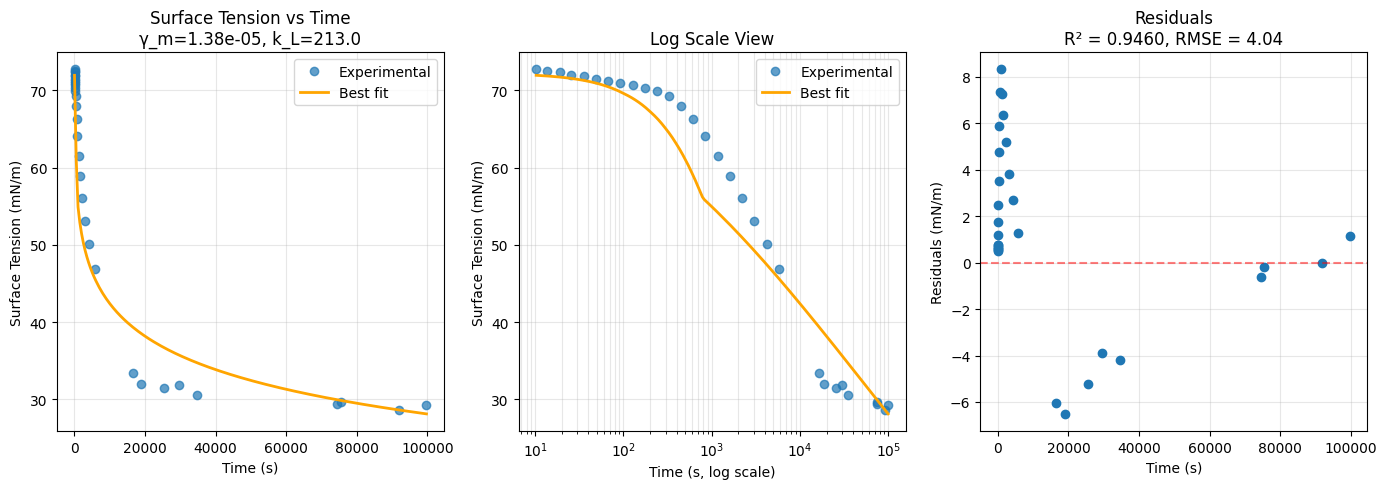

In [20]:
# Test the function
print("Testing curve_fit_ward_tordai function:")
test_times = np.array([10, 100, 1000, 10000])
test_results = curve_fit_ward_tordai(test_times, gamma_m=3.91e-6, kl=2146.0)

for t, st in zip(test_times, test_results):
    print(f"  t={t:6.0f}s -> ST={st:8.3f} mN/m")

age, sft=read_data("C:\Arbeit\Programme\DST\Dynamic-Surface-Tension\Example Data\C12E4_0.1g.txt")

print(f"\nExperimental data for comparison:")
print(f"  t={age.iloc[0]:.2f}s, ST={sft.iloc[0]:.2f} mN/m")
print(f"  t={age.iloc[-1]:.2f}s, ST={sft.iloc[-1]:.2f} mN/m")

# Now try fitting with better initial guesses and bounds
print("\n" + "="*60)
print("Fitting parameters...")
print("="*60)

try:
    # Try multiple initial guesses to find best fit
    best_r2 = -np.inf
    best_result = None
    
    initial_guesses = [
        [4e-6, 2000.0],
        [6e-6, 1000.0],
        [1e-5, 500.0],
        [5e-6, 1500.0]
    ]
    
    for p0 in initial_guesses:
        try:
            popt, pcov = scipy.optimize.curve_fit(
                curve_fit_ward_tordai,
                age.values, sft.values,
                p0=p0,
                bounds=([1e-7, 10.0], [5e-5, 10000.0]),  # Wider bounds
                maxfev=10000
            )
            
            # Calculate R²
            fitted_sft = curve_fit_ward_tordai(age.values, popt[0], popt[1])
            residuals = sft.values - fitted_sft
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((sft.values - np.mean(sft.values))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            if r_squared > best_r2:
                best_r2 = r_squared
                best_result = (popt, pcov, fitted_sft)
                print(f"  Initial guess {p0} -> R²={r_squared:.4f}, γ_m={popt[0]:.3e}, k_L={popt[1]:.1f}")
        
        except Exception as e:
            print(f"  Initial guess {p0} failed: {e}")
            continue
    
    if best_result is None:
        raise ValueError("All fitting attempts failed")
    
    popt, pcov, fitted_sft = best_result
    residuals = sft.values - fitted_sft
    
    print(f"\n{'='*60}")
    print(f"BEST FIT RESULTS:")
    print(f"{'='*60}")
    print(f"Fitted gamma_m: {popt[0]:.3e} mol/m²")
    print(f"Fitted kl: {popt[1]:.2f} m³/mol")
    print(f"Standard errors: gamma_m=±{np.sqrt(pcov[0,0]):.3e}, kl=±{np.sqrt(pcov[1,1]):.2f}")
    print(f"R² = {best_r2:.4f}")
    print(f"RMSE = {np.sqrt(np.mean(residuals**2)):.3f} mN/m")
    
    # Plot results
    plt.figure(figsize=(14, 5))
    
    # Plot 1: Full data with fit
    plt.subplot(1, 3, 1)
    plt.plot(age, sft, 'o', label='Experimental', markersize=6, alpha=0.7)
    t_fine = np.linspace(age.min(), age.max(), 200)
    plt.plot(t_fine, curve_fit_ward_tordai(t_fine, popt[0], popt[1]), 
             '-', label=f'Best fit', linewidth=2, color='orange')
    plt.xlabel('Time (s)')
    plt.ylabel('Surface Tension (mN/m)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f'Surface Tension vs Time\nγ_m={popt[0]:.2e}, k_L={popt[1]:.1f}')
    
    # Plot 2: Log scale
    plt.subplot(1, 3, 2)
    plt.semilogx(age, sft, 'o', label='Experimental', markersize=6, alpha=0.7)
    t_fine_log = np.logspace(np.log10(age.min()), np.log10(age.max()), 200)
    plt.semilogx(t_fine_log, curve_fit_ward_tordai(t_fine_log, popt[0], popt[1]), 
                 '-', label='Best fit', linewidth=2, color='orange')
    plt.xlabel('Time (s, log scale)')
    plt.ylabel('Surface Tension (mN/m)')
    plt.legend()
    plt.grid(True, alpha=0.3, which='both')
    plt.title('Log Scale View')
    
    # Plot 3: Residuals
    plt.subplot(1, 3, 3)
    plt.plot(age, residuals, 'o', markersize=6)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Residuals (mN/m)')
    plt.grid(True, alpha=0.3)
    plt.title(f'Residuals\nR² = {best_r2:.4f}, RMSE = {np.sqrt(np.mean(residuals**2)):.2f}')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Fitting failed with error: {e}")
    import traceback
    traceback.print_exc()


In [ ]:
# Debug: check with smaller time range and step
params_test = WardTordaiParams(
    gamma_m=3.91e-6,
    kl=2146.0,
    T=1000.0,  # Smaller time range
    h=10.0,    # Larger step
    isotherm=2,
    geometry=0
)

try:
    t_sim, gamma_sim, st_sim, acc = ward_tordai(params_test)
    
    print("Ward-Tordai output:")
    print(f"  Number of points: {len(t_sim)}")
    print(f"  Time range: {t_sim[0]:.1f} to {t_sim[-1]:.1f} s")
    print(f"  Gamma range: {min(gamma_sim):.3e} to {max(gamma_sim):.3e} mol/m²")
    print(f"  gamma_m: {params_test.gamma_m:.3e}")
    print(f"  Max gamma/gamma_m: {max(gamma_sim)/params_test.gamma_m:.4f}")
    print(f"  ST range: {min(st_sim)*1000:.3f} to {max(st_sim)*1000:.3f} mN/m")
    print(f"  Convergence: {acc}")
    
    # Print some values
    print("\nSample points:")
    for i in [1, 10, 20, 50, -1]:
        if i < len(t_sim):
            idx = i if i >= 0 else len(t_sim) + i
            print(f"  t={t_sim[idx]:8.1f}s, γ={gamma_sim[idx]:.3e}, γ/γ_m={gamma_sim[idx]/params_test.gamma_m:.4f}, ST={st_sim[idx]*1000:.3f} mN/m")

except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()


Ward-Tordai output:
  Number of points: 101
  Time range: 0.0 to 1000.0 s
  Gamma range: 0.000e+00 to 3.268e-06 mol/m²
  gamma_m: 3.910e-06
  Max gamma/gamma_m: 0.8359
  ST range: 54.682 to 72.200 mN/m
  Convergence: True

Sample points:
  t=    10.0s, γ=8.129e-07, γ/γ_m=0.2079, ST=69.941 mN/m
  t=   100.0s, γ=2.851e-06, γ/γ_m=0.7292, ST=59.539 mN/m
  t=   200.0s, γ=2.996e-06, γ/γ_m=0.7663, ST=58.112 mN/m
  t=   500.0s, γ=3.162e-06, γ/γ_m=0.8086, ST=56.175 mN/m
  t=  1000.0s, γ=3.268e-06, γ/γ_m=0.8359, ST=54.682 mN/m
